In [ ]:
import os
import pandas as pd
import numpy as np
from datetime import datetime


import matplotlib.pyplot as plt
from importlib import reload

import Tree
reload(Tree)
from Tree import *

import forecast_prophet
reload(forecast_prophet)
from forecast_prophet import *

import utils
reload(utils)
from utils import *

import main
reload(main)
from main import *



c:\Users\31683\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# M5

In [1036]:
Y_path=os.getcwd()+f"\\data\\M5\\sales_train_validation.csv"  # to data file 
Y_path_eval= os.getcwd()+f"\\data\\M5\\sales_train_evaluation.csv" 
X_path_val_eval=os.getcwd()+f"\\data\\M5\\prices_train_val_eval.csv"  # to data file

dfHolidays=pd.read_csv(os.getcwd()+f"\\data\\M5\\holidays.csv")
iOoS=28

lMethods=["bottom_up", "top_down_ph" ,"top_down_hp","ols","diag" ,"full" ,"mint_shrink" ]

mX  = get_mX(X_path_val_eval)

vW=np.loadtxt(os.getcwd()+f"\\data\\M5\\weights.txt")
vW=vW[:114]
vW=vW/vW[0]



c:\Users\31683\Desktop\M5-1\main.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[level]=None


In [15]:
os.getcwd()

'c:\\Users\\31683\\Desktop\\M5-1'

In [1037]:
def return_vWRMSSE(mY, mYtrue,mYpred, vW):
    vRMSSE=np.sqrt(np.mean((mYtrue-mYpred)**2 , axis=1)  / np.mean( (mY[:,1:] - mY[:,:-1])**2 , axis=1))
    vWRMSSE=vW*vRMSSE
    
    return vWRMSSE

In [1038]:
def slice_vWRMSSE(vWRMSSE, slices):
    vSlices=[]

    start=len(vWRMSSE)
    for slice in slices:
        end = start 
        start = end - slice
        vSlices.append(np.sum(vWRMSSE[start:end]))    
    vSlices=vSlices[::-1]
    
    return np.hstack([vSlices,np.sum(vWRMSSE)])     

### M5 default Prophet

In [1283]:


tree=Tree(data_directory=Y_path, type='spatial')
tree_eval=Tree(data_directory=Y_path_eval, type='spatial')
tree.forecast_Prophet(iOoS=iOoS, dfHolidays=dfHolidays)

slices = [len([sublist for sublist in tree.list_of_leafs if sublist.count(None) == i]) for i, _ in enumerate(tree.levels)]
slices.append(1)
    

c:\Users\31683\Desktop\M5-1\Tree.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[level]=None
c:\Users\31683\Desktop\M5-1\Tree.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[level]=None


KeyboardInterrupt: 

In [ ]:
mResults=np.zeros((len(slices)+1 , len(lMethods)))
for j,method in enumerate(lMethods):
    tree.reconcile(method)
    
    vWRMSSE=return_vWRMSSE(mY=tree.mY,
                           mYtrue=tree_eval.mY,
                           mYpred=tree.mYtilde,
                           vW=vW)
    vSlicedWRMSSE=slice_vWRMSSE(vWRMSSE, slices)
    mResults[:,j]=vSlicedWRMSSE

dfResults = matrix_to_df(np.round(mResults,2),
                        ['Total','State','Store','Cat.','Dept.','Average'], #TODO 
                        lMethods)

In [734]:
dfResults

,bottom_up,top_down_ph,top_down_hp,ols,diag,full,mint_shrink
Total,0.78,0.77,0.77,0.77,0.78,0.67,0.76
State,0.78,0.84,0.85,0.78,0.78,0.70,0.77
Store,0.83,1.13,1.15,0.82,0.82,0.74,0.81
Cat.,0.85,1.15,1.18,0.85,0.85,0.76,0.84
Dept.,0.88,1.20,1.23,0.88,0.88,0.80,0.87
Average,4.11,5.09,5.18,4.09,4.11,3.67,4.04


### M5 Tuned Prophet

In [736]:
tree=Tree(data_directory=Y_path, type='spatial')
tree_eval=Tree(data_directory=Y_path_eval, type='spatial')

with open(os.getcwd()+'\\data\\M5\\ddParams_20241007_232407.pkl', 'rb') as file:
    ddParams  = pickle.load(file) 
tree.ddParams=ddParams    
tree.forecast_Prophet(iOoS=iOoS, dfHolidays=dfHolidays)

slices = [len([sublist for sublist in tree.list_of_leafs if sublist.count(None) == i]) for i, _ in enumerate(tree.levels)]
slices.append(1)

mResults=np.zeros((len(slices)+1 , len(lMethods)))
for j,method in enumerate(lMethods):
    tree.reconcile(method)
    
    vWRMSSE=return_vWRMSSE(mY=tree.mY,
                           mYtrue=tree_eval.mY,
                           mYpred=tree.mYtilde,
                           vW=vW)
    vSlicedWRMSSE=slice_vWRMSSE(vWRMSSE, slices) 
    mResults[:,j]=vSlicedWRMSSE

dfResults = matrix_to_df(np.round(mResults,2),
                        ['Total','State','Store','Cat.','Dept.','Average'], #TODO 
                        lMethods)

dfResults


c:\Users\31683\Desktop\M5-1\Tree.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[level]=None
c:\Users\31683\Desktop\M5-1\Tree.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[level]=None


Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete


,bottom_up,top_down_ph,top_down_hp,ols,diag,full,mint_shrink
Total,0.78,0.77,0.77,0.77,0.78,0.67,0.76
State,0.78,0.84,0.85,0.78,0.78,0.70,0.77
Store,0.83,1.13,1.15,0.82,0.82,0.74,0.81
Cat.,0.85,1.15,1.18,0.85,0.85,0.76,0.84
Dept.,0.88,1.20,1.23,0.88,0.88,0.80,0.87
Average,4.11,5.09,5.18,4.09,4.11,3.67,4.04


#### M5 Default Prophet with Price

In [740]:
tree=Tree(data_directory=Y_path, type='spatial')
tree_eval=Tree(data_directory=Y_path_eval, type='spatial')

# with open(os.getcwd()+'\\data\\M5\\ddParams_20241007_232407.pkl', 'rb') as file:
#     ddParams  = pickle.load(file) 
# tree.ddParams=ddParams    
tree.forecast_Prophet(iOoS=iOoS, mX = mX[:,:-iOoS] , dfHolidays=dfHolidays )

slices = [len([sublist for sublist in tree.list_of_leafs if sublist.count(None) == i]) for i, _ in enumerate(tree.levels)]
slices.append(1)

mResults=np.zeros((len(slices)+1 , len(lMethods)))
for j,method in enumerate(lMethods):
    tree.reconcile(method)
    
    vWRMSSE=return_vWRMSSE(mY=tree.mY,
                           mYtrue=tree_eval.mY,
                           mYpred=tree.mYtilde,
                           vW=vW)
    vSlicedWRMSSE=slice_vWRMSSE(vWRMSSE, slices) 
    mResults[:,j]=vSlicedWRMSSE

dfResults = matrix_to_df(np.round(mResults,2),
                        ['Total','State','Store','Cat.','Dept.','Average'], #TODO 
                        lMethods)

dfResults


c:\Users\31683\Desktop\M5-1\Tree.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[level]=None
c:\Users\31683\Desktop\M5-1\Tree.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[level]=None


Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete


,bottom_up,top_down_ph,top_down_hp,ols,diag,full,mint_shrink
Total,0.77,0.77,0.77,0.77,0.78,0.83,0.79
State,0.77,0.84,0.85,0.78,0.78,0.82,0.79
Store,0.82,1.13,1.15,0.82,0.82,0.85,0.82
Cat.,0.85,1.15,1.18,0.85,0.85,0.85,0.83
Dept.,0.88,1.20,1.23,0.88,0.88,0.88,0.87
Average,4.08,5.09,5.18,4.10,4.12,4.22,4.11


# Perform CV using tuned params

In [60]:
Y_path=os.getcwd()+f"\\data\\M5\\sales_train_validation.csv"  # to data file 
X_path=os.getcwd()+f"\\data\\M5\\prices_train_val_eval.csv"  # to data file

dfHolidays=pd.read_csv(os.getcwd()+f"\\data\\M5\\holidays.csv")


initial=1548
period=7
horizon=28   

tree_cv_tuned=Tree( data_directory = Y_path , type='spatial') 
with open(os.getcwd()+'\\data\\M5\\ddParams_20241007_232407.pkl', 'rb') as file:
    ddParams  = pickle.load(file) 
tree_cv_tuned.ddParams=ddParams
dOutputs  = tree_cv_tuned.cross_validation(dfHolidays,initial, period, horizon)

with open(os.getcwd()+f"\\data\\M5\\dCVOutputs_tuned_new.pkl", "wb") as myFile:
    pickle.dump(dOutputs, myFile)
    
    
slices = [len([sublist for sublist in tree_cv_tuned.list_of_leafs if sublist.count(None) == i]) for i, _ in enumerate(tree_cv_tuned.levels)]
slices.append(1)

c:\Users\31683\Desktop\M5-1\Tree.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[level]=None


Number of iterations is 49
CV iterations completed = 1 of 49
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
CV iterations completed = 2 of 49
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
CV iterations completed = 3 of 49
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
CV iterations completed = 4 of 49
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete


Optimization terminated abnormally. Falling back to Newton.


CV iterations completed = 28 of 49
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
CV iterations completed = 29 of 49
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
CV iterations completed = 30 of 49
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
CV iterations completed = 31 of 49
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is compl

# Tune and Perform CV

In [ ]:

initial=1548
period=28
horizon=28   

tree_tuned=Tree( data_directory = Y_path , type='spatial') 
tree_tuned.tune_Prophet(random_size=101,initial=int(initial*0.7), period=period, horizon=horizon)
# output ddParams_timestamp.pkl to data folder 
dOutputs  = tree_tuned.cross_validation(dfHolidays,initial, period, horizon)

with open(os.getcwd()+f"\\data\\M5\\dCVOutputs_tuned_new.pkl", "wb") as myFile:
    pickle.dump(dOutputs, myFile)

# Forecast Tree using tuned parameters

In [18]:
with open(os.getcwd()+'\\data\\M5\\ddParams_20241007_232407.pkl', 'rb') as file:
    ddParams  = pickle.load(file) 
    
tree_tuned=Tree( data_directory = Y_path , type='spatial') 
tree_tuned.forecast_Prophet(iOoS=28 , dfHolidays=dfHolidays, ddParams=ddParams)

slices = [len([sublist for sublist in tree_tuned.list_of_leafs if sublist.count(None) == i]) for i, _ in enumerate(tree_tuned.levels)]
slices.append(1)
 

c:\Users\31683\Desktop\M5-1\Tree.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[level]=None


In [81]:
# i=0
# plt.plot(tree_tuned.mRes[i,-60:])
# plt.title(f"Tuned mRes for leaf {i}")
# plt.show()



array([9.46259554e-05, 3.51529669e-04, 2.53059432e-03, 7.17341610e-05,
       3.62405874e-03, 4.77660582e-04, 8.19780401e-04, 3.90345729e-03,
       1.35001352e-02, 2.68146509e-03, 2.73715449e-03, 2.61453702e-03,
       4.13659808e-04, 2.75198628e-03, 1.02695180e-02, 2.63111297e-01,
       1.16146201e-01, 8.58216947e-04, 2.08073396e-01, 3.47217436e-03,
       3.04869079e-03, 1.81643528e-02, 2.49401315e-02, 2.15359118e-02,
       4.00168116e-02, 1.62102839e-01, 7.70541404e-03, 1.19802550e-01,
       5.54298936e-02, 1.46768121e-03, 5.53260871e-02, 7.19703207e-03,
       7.53461186e-04, 4.45672136e-02, 1.18725449e-01, 3.03617797e-03,
       8.19493221e-02, 7.73960092e-03, 3.63445933e-03, 8.98833401e-02,
       1.42855274e-02, 2.72464065e-03, 8.00914589e-03, 8.69458416e-03,
       8.01257935e-03, 8.00461900e-03, 7.54018943e-03, 2.73348980e-01,
       2.82415033e-01, 1.29994510e-01, 1.32025255e-01, 9.94410676e-04,
       1.22219973e-03, 6.15116869e-04, 2.08095351e-01, 2.09151823e-01,
      

# Perform CV using default params

In [61]:
Y_path=os.getcwd()+f"\\data\\M5\\sales_train_validation.csv"  # to data file 
X_path=os.getcwd()+f"\\data\\M5\\prices_train_val_eval.csv"  # to data file

dfHolidays=pd.read_csv(os.getcwd()+f"\\data\\M5\\holidays.csv")


initial=1548
period=7
horizon=28   

tree_default=Tree( data_directory = Y_path , type='spatial') 
dOutputs  = tree_default.cross_validation(dfHolidays,initial, period, horizon)

with open(os.getcwd()+f"\\data\\M5\\dCVOutputs_default_new.pkl", "wb") as myFile:
    pickle.dump(dOutputs, myFile)
    
slices = [len([sublist for sublist in tree_default.list_of_leafs if sublist.count(None) == i]) for i, _ in enumerate(tree_default.levels)]
slices.append(1)

c:\Users\31683\Desktop\M5-1\Tree.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[level]=None


Number of iterations is 49
CV iterations completed = 1 of 49
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
CV iterations completed = 2 of 49
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
CV iterations completed = 3 of 49
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
CV iterations completed = 4 of 49
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete
Reconciliation is complete


# Forecast Tree using default parameters

In [50]:
   
tree_default=Tree( data_directory = Y_path , type='spatial') 
tree_default.forecast_Prophet(iOoS=28 , dfHolidays=dfHolidays, ddParams=None)

slices = [len([sublist for sublist in tree_default.list_of_leafs if sublist.count(None) == i]) for i, _ in enumerate(tree_default.levels)]
slices.append(1)

c:\Users\31683\Desktop\M5-1\Tree.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[level]=None


Reconciliation is complete


<function matplotlib.pyplot.show(close=None, block=None)>

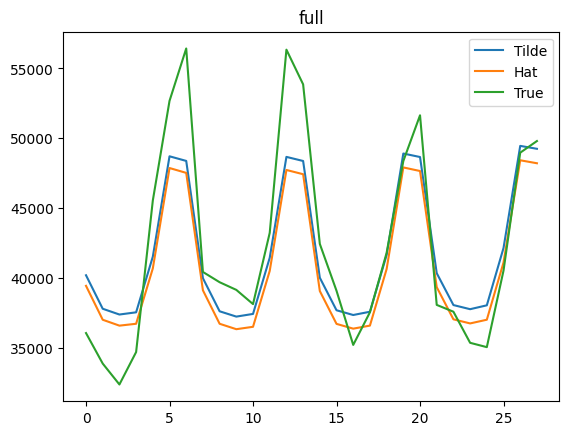

In [52]:
method='full'
tree_default.reconcile(method)

l=0
plt.plot(tree_default.mYtilde[l,:], label='Tilde')
plt.plot(tree_default.mYhat[l,:], label='Hat')
plt.plot(tree_default.mY[l,-28:], label='True')
plt.legend()
plt.title(method+" "+'default')
plt.show

# Forecast Tree using Tuned parameters

In [53]:
with open(os.getcwd()+'\\data\\M5\\ddParams_20241007_232407.pkl', 'rb') as file:
    ddParams  = pickle.load(file)   
tree_tuned=Tree( data_directory = Y_path , type='spatial') 
tree_tuned.forecast_Prophet(iOoS=28 , dfHolidays=dfHolidays, ddParams=ddParams)

slices = [len([sublist for sublist in tree_tuned.list_of_leafs if sublist.count(None) == i]) for i, _ in enumerate(tree_tuned.levels)]
slices.append(1)

c:\Users\31683\Desktop\M5-1\Tree.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[level]=None


Reconciliation is complete


<function matplotlib.pyplot.show(close=None, block=None)>

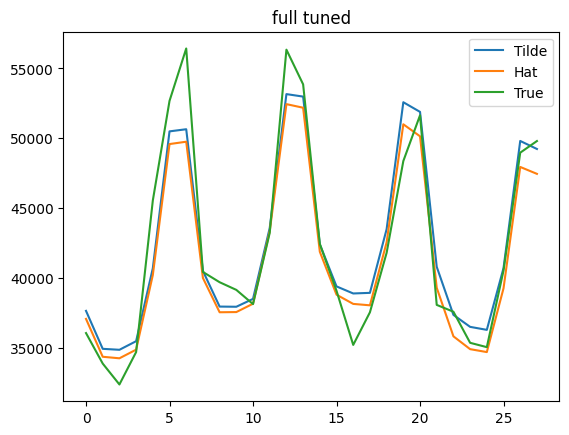

In [54]:
method='full'
tree_tuned.reconcile(method)

l=0
plt.plot(tree_tuned.mYtilde[l,:], label='Tilde')
plt.plot(tree_tuned.mYhat[l,:], label='Hat')
plt.plot(tree_tuned.mY[l,-28:], label='True')
plt.legend()
plt.title(method+" "+'tuned')
plt.show



# read dOutputs of already completed CVs

In [63]:
with open(os.getcwd()+'\\data\\M5\\dCVOutputs_default_new.pkl', 'rb') as file:
    dOutputs_default  = pickle.load(file) 
with open(os.getcwd()+'\\data\\M5\\dCVOutputs_tuned_new.pkl', 'rb') as file:
    dOutputs_tuned  = pickle.load(file) 
tree_default=Tree( data_directory = Y_path , type='spatial')  
slices = [len([sublist for sublist in tree_default.list_of_leafs if sublist.count(None) == i]) for i, _ in enumerate(tree_default.levels)]
slices.append(1)

    

c:\Users\31683\Desktop\M5-1\Tree.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[level]=None


# Plots and Tables

In [18]:
tree_=Tree( data_directory = Y_path , type='spatial') 
slices = [len([sublist for sublist in tree_.list_of_leafs if sublist.count(None) == i]) for i, _ in enumerate(tree_.levels)]
slices.append(1)

c:\Users\31683\Desktop\M5-1\Tree.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[level]=None


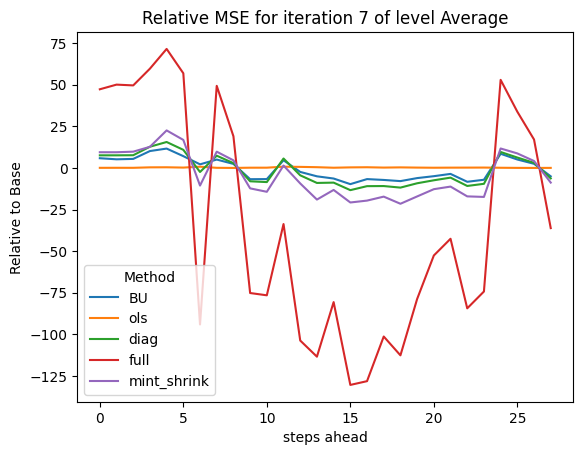

In [1245]:
dOutputs=dOutputs_default

iter=7
relative='Base'
level='Average'
iters=int(dOutputs_default['bottom_up']['mYhat'].shape[1]/28)
metric='MSE'

vMethods=getCVResults( h=1, dOutputs=dOutputs , vW=vW, metric=metric , slices=slices  ,
                      iters = None, rolling=True).columns.get_level_values(0).unique()
vMethods=vMethods.drop(['top_down_ph','top_down_hp'])

plt.figure()
for method in vMethods:
    vValues = np.zeros(28)
    
    for h in range(1, 29):
        df = getCVResults(h=h, dOutputs=dOutputs_default, vW=vW, metric=metric, slices=slices, 
                          iters=iter, 
                          rolling=False)[method]
        vValues[h-1] = df[df.index == level][relative].item()    
    plt.plot(np.arange(28), vValues, label=method)

plt.legend(title="Method")
plt.xlabel("steps ahead")
plt.ylabel(f"Relative to {relative}")
plt.title(f"Relative {metric} for iteration {iter} of level {level}")

# Show the plot
plt.show()


## Plot of iterations per h


In [32]:
import utils
reload(utils)
from utils import *

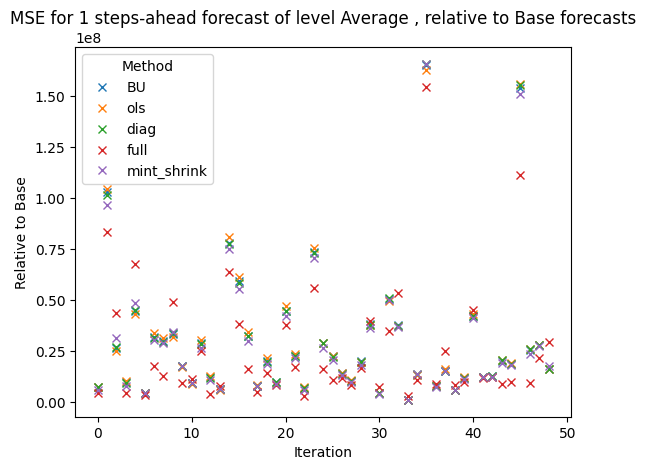

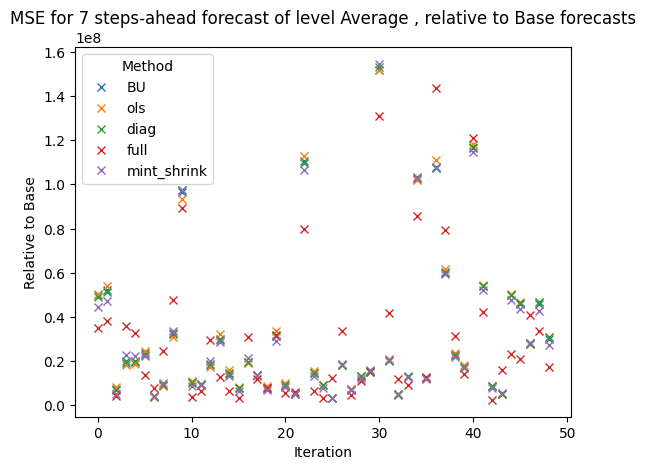

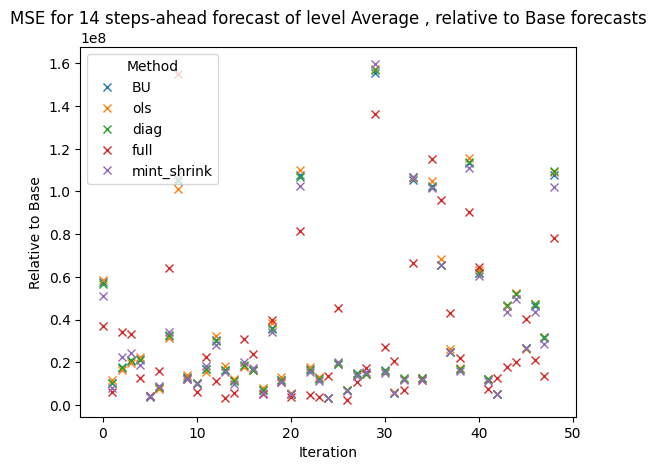

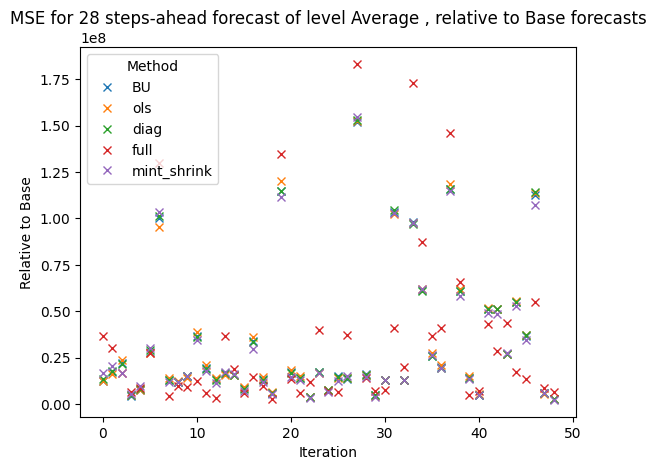

In [1172]:
dOutputs=dOutputs_default
relative='Base'
level='Average'
iters=int(dOutputs['bottom_up']['mYhat'].shape[1]/28)
metric='MSE'



vMethods=getCVResults( h=1, dOutputs=dOutputs , metric=metric , slices=slices ,iters = None, rolling=True).columns.get_level_values(0).unique()
vMethods=vMethods.drop(['top_down_ph','top_down_hp'])

plt.figure()
for h in [1,7,14,28]:
    for method in vMethods:
        vValues = np.zeros(iters)
        
        for iter in range(1, iters+1):
            df = getCVResults(h=h, dOutputs=dOutputs, metric=metric, 
                            slices=slices, 
                            iters=iter, 
                            rolling=False,
                            relative=False)[method]
            vValues[iter-1] = df[df.index == level].item()    
        plt.plot(np.arange(iters), vValues,'x' ,label=method)

    plt.legend(title="Method")
    plt.xlabel("Iteration")
    plt.ylabel(f"Relative to {relative}")
    plt.title(f"{metric} for {h} steps-ahead forecast of level {level} , relative to {relative} forecasts")

    # Show the plot
    plt.show()

    
    
    



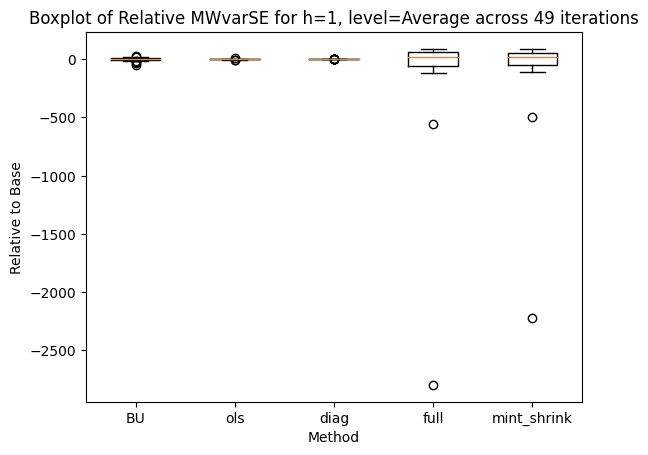

          min   max   mean  median       var
BU     -46.53 29.05   0.27    3.02    160.79
ols     -8.16  9.00   0.43    0.65      7.69
diag    -0.01  0.22   0.02    0.00      0.00
full -2795.42 89.85 -61.09   22.21 165517.69
mint -2221.96 88.42 -46.91   20.19 106620.27


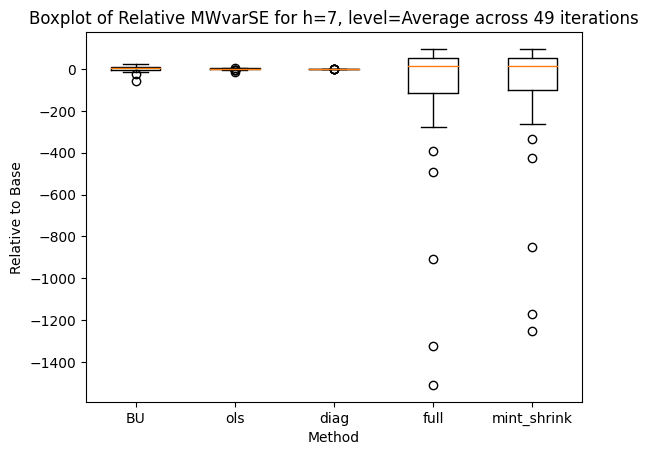

          min   max   mean  median       var
BU     -59.78 20.76   0.71    2.62    162.83
ols    -13.04  5.69   0.14    0.88      9.34
diag     0.00  0.89   0.04    0.01      0.02
full -1507.49 94.94 -99.23   13.76 103647.80
mint -1251.12 95.39 -85.31   12.26  79091.84


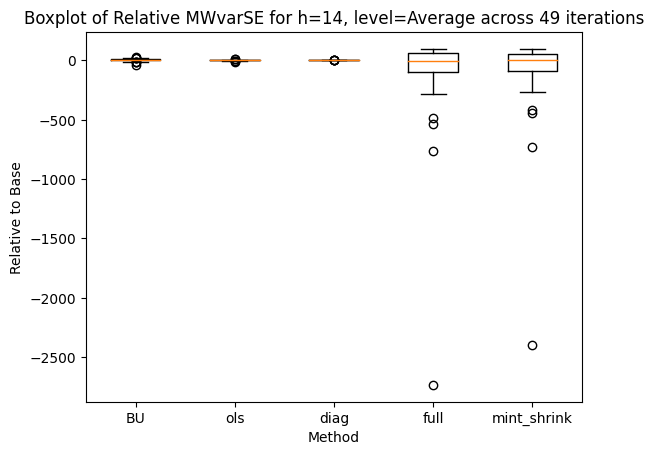

          min   max    mean  median       var
BU     -43.68 25.67    2.45    2.99    141.15
ols    -11.41 11.97    0.64    0.78     11.61
diag     0.00  0.61    0.04    0.01      0.01
full -2732.98 97.08 -110.10   -3.59 173020.08
mint -2397.16 95.66  -94.69   -1.40 134890.26


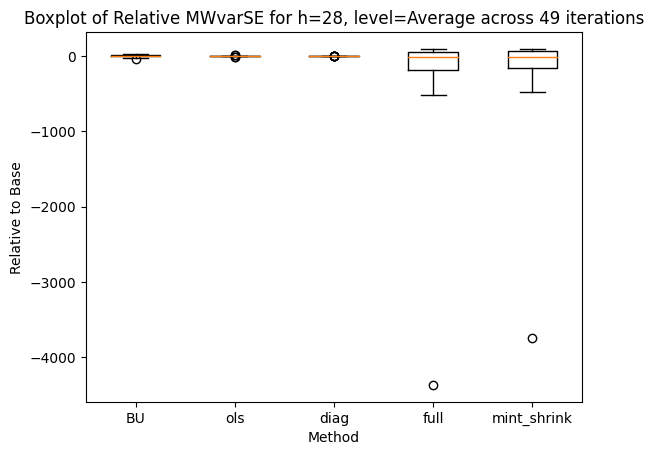

          min   max    mean  median       var
BU     -38.77 31.54    1.42    2.23    190.76
ols    -11.66 10.69    0.15    0.66     13.36
diag     0.00  1.15    0.09    0.02      0.05
full -4366.64 93.41 -154.82  -14.45 395501.90
mint -3740.63 96.98 -129.23  -11.96 292635.58


In [45]:
dOutputs=dOutputs_default
# dOutputs=dOutputs_tuned
relative='Base'
level='Average'
iters=int(dOutputs['bottom_up']['mYhat'].shape[1]/28)
metric="MWvarSE"

vMethods=getCVResults( h=1, dOutputs=dOutputs ,  metric=metric , slices=slices ,iters = None, rolling=True).columns.get_level_values(0).unique()
vMethods=vMethods.drop(['top_down_ph','top_down_hp'])


### Here we should calculate the loss for each iteration , then plot the loss


plt.figure()
for h in [1,7,14,28]:
    data = []  # To store values for each method
    labels = []  # To store method names as labels
    
    for method in vMethods:
        vValues = np.zeros(iters)
        
        for iter in range(1, iters+1):
            df = getCVResults(h=h, dOutputs=dOutputs,  metric=metric, 
                              slices=slices, 
                              iters=iter, 
                              rolling=False, relative=True)[method]
            vValues[iter-1] = df[df.index == level][relative].item()
        
        # Collect all values for the boxplot
        data.append(vValues)
        labels.append(method)
        
        

    # Create a boxplot for the current `h` step-ahead forecast
    plt.boxplot(data, labels=labels,showfliers=True)
    
    plt.xlabel("Method")
    plt.ylabel(f"Relative to {relative}")
    plt.title(f"Boxplot of Relative {metric} for h={h}, level={level} across {iters} iterations")

    # Show the plot
    plt.show()
    
    #print stats
    mData=np.vstack((np.min(data,axis=1),                 
                np.max(data,axis=1),
                np.mean(data,axis=1),
                np.median(data,axis=1),
                np.var(data,axis=1)
                ))
    dfStats=pd.DataFrame(data=mData.T, columns=['min', 'max', 'mean','median','var'], 
                         index=['BU','ols','diag','mint_full','mint_shrink','mint_diag']
                     )
    print(dfStats)

    



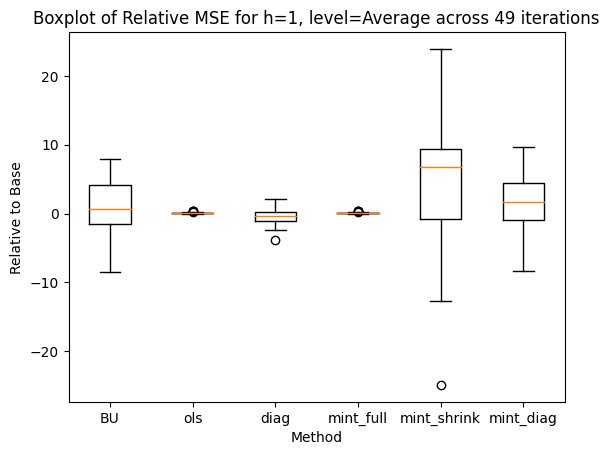

               min   max  mean  median   var
BU           -8.46  7.89  1.02    0.59 13.78
ols           0.00  0.39  0.09    0.04  0.01
diag         -3.89  2.13 -0.45   -0.35  1.42
mint_full     0.00  0.39  0.09    0.04  0.01
mint_shrink -24.87 23.92  4.76    6.71 77.84
mint_diag    -8.42  9.66  1.64    1.66 18.39


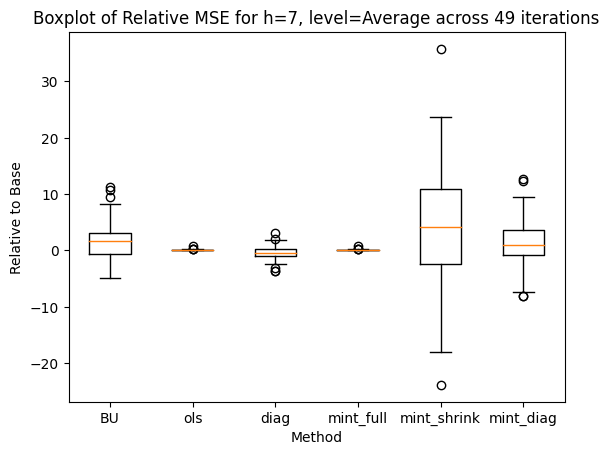

               min   max  mean  median    var
BU           -4.88 11.18  1.70    1.66  14.85
ols           0.00  0.74  0.11    0.07   0.02
diag         -3.74  3.02 -0.41   -0.48   1.70
mint_full     0.00  0.74  0.11    0.07   0.02
mint_shrink -23.86 35.80  3.96    4.14 127.92
mint_diag    -8.09 12.74  1.64    0.94  24.06


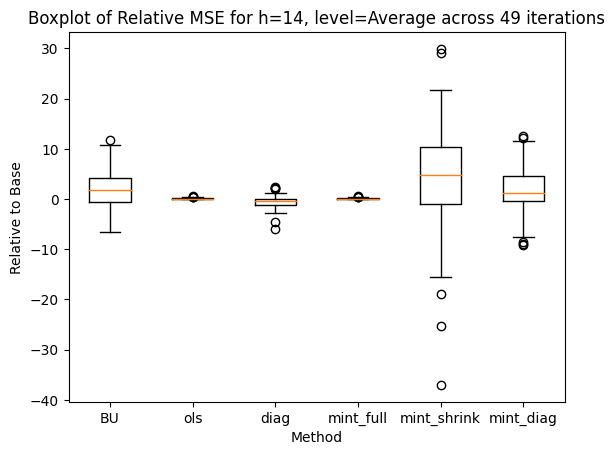

               min   max  mean  median    var
BU           -6.62 11.66  1.88    1.81  17.34
ols           0.00  0.62  0.13    0.08   0.02
diag         -5.89  2.42 -0.51   -0.31   2.28
mint_full     0.00  0.62  0.13    0.08   0.02
mint_shrink -37.00 29.91  3.80    4.76 145.48
mint_diag    -9.15 12.57  1.87    1.22  27.50


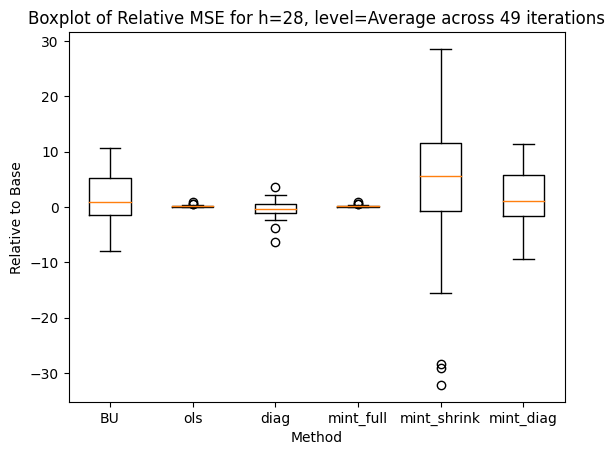

               min   max  mean  median    var
BU           -7.93 10.57  1.50    0.92  21.20
ols           0.00  0.84  0.16    0.11   0.03
diag         -6.37  3.62 -0.34   -0.39   2.70
mint_full     0.00  0.84  0.16    0.11   0.03
mint_shrink -32.13 28.56  4.34    5.67 163.68
mint_diag    -9.44 11.37  1.61    1.00  27.04


In [72]:
dOutputs=dOutputs_default
# dOutputs=dOutputs_tuned
relative='Base'
level='Average'
iters=int(dOutputs['bottom_up']['mYhat'].shape[1]/28)
metric='MSE'

vMethods=getCVResults( h=1, dOutputs=dOutputs , metric=metric , slices=slices ,iters = None, rolling=True).columns.get_level_values(0).unique()
vMethods=vMethods.drop(['top_down_ph','top_down_hp'])


### Here we should calculate the loss for each iteration , then plot the loss


plt.figure()
for h in [1,7,14,28]:
    data = []  # To store values for each method
    labels = []  # To store method names as labels
    
    for method in vMethods:
        vValues = np.zeros(iters)
        
        for iter in range(1, iters+1):
            df = getCVResults(h=h, dOutputs=dOutputs, metric=metric, 
                              slices=slices, 
                              iters=iter, 
                              rolling=False, relative=True)[method]
            vValues[iter-1] = df[df.index == level][relative].item()
        
        # Collect all values for the boxplot
        data.append(vValues)
        labels.append(method)
        
        

    # Create a boxplot for the current `h` step-ahead forecast
    plt.boxplot(data, labels=labels,showfliers=True)
    
    plt.xlabel("Method")
    plt.ylabel(f"Relative to {relative}")
    plt.title(f"Boxplot of Relative {metric} for h={h}, level={level} across {iters} iterations")

    # Show the plot
    plt.show()
    
    #print stats
    mData=np.vstack((np.min(data,axis=1),                 
                np.max(data,axis=1),
                np.mean(data,axis=1),
                np.median(data,axis=1),
                np.var(data,axis=1)
                ))
    dfStats=pd.DataFrame(data=mData.T, columns=['min', 'max', 'mean','median','var'], 
                         index=['BU','ols','diag','mint_full','mint_shrink','mint_diag']
                     )
    print(dfStats)

    



In [55]:
vValues.var()

25095551104250.684

BU
36574353055129.87
ols
26325245382717.62
diag
27959259244339.31
mint_full
26325245382717.62
mint_shrink
42771131140731.46
mint_diag
30545884443923.742


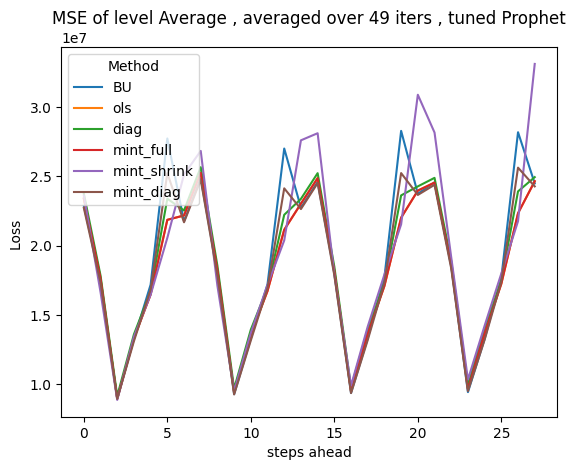

In [64]:
dOutputs=dOutputs_tuned

level='Average'
iters=int(dOutputs_default['bottom_up']['mYhat'].shape[1]/28)
metric='MSE'

vMethods=getCVResults( h=1, dOutputs=dOutputs , metric=metric , slices=slices  ,
                      iters = None, rolling=False).columns.get_level_values(0).unique()
vMethods=vMethods.drop(['top_down_ph','top_down_hp'])

plt.figure()
for method in vMethods:
    vValues = np.zeros(28)
    
    for h in range(1, 29):
        df = getCVResults(h=h, dOutputs=dOutputs , metric=metric, slices=slices, 
                          iters=None, 
                          rolling=False, relative=False)[method]
        vValues[h-1] = df[df.index == level].item() 
        
    print(method)
    print(vValues.var())       
    plt.plot(np.arange(28), vValues, label=method)

plt.legend(title="Method")
plt.xlabel("steps ahead")
plt.ylabel(f"Loss ")
plt.title(f"{metric} of level {level} , averaged over {iters} iters , tuned Prophet")

# Show the plot
plt.show()

Above we see different from default. OLS has the lowest variance, then diag and full has the highest. Why?


BU
49272874131107.31
ols
51729562920389.086
diag
52003550253369.86
mint_full
51729562920389.086
mint_shrink
45515007270152.92
mint_diag
49540650744104.35


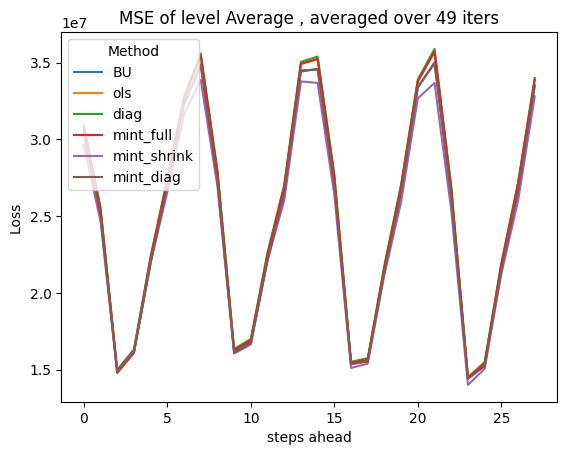

In [68]:
dOutputs=dOutputs_default

level='Average'
iters=int(dOutputs_default['bottom_up']['mYhat'].shape[1]/28)
metric='MSE'

vMethods=getCVResults( h=1, dOutputs=dOutputs , metric=metric , slices=slices  ,
                      iters = None, rolling=True).columns.get_level_values(0).unique()
vMethods=vMethods.drop(['top_down_ph','top_down_hp'])

plt.figure()
for method in vMethods:
    vValues = np.zeros(28)
    
    for h in range(1, 29):
        df = getCVResults(h=h, dOutputs=dOutputs ,metric=metric, slices=slices, 
                          iters=None, 
                          rolling=False, relative=False)[method]
        vValues[h-1] = df[df.index == level].item()    
    plt.plot(np.arange(28), vValues, label=method)
    print(method)
    print(vValues.var())  
plt.legend(title="Method")
plt.xlabel("steps ahead")
plt.ylabel(f"Loss ")
plt.title(f"{metric} of level {level} , averaged over {iters} iters")

# Show the plot
plt.show()




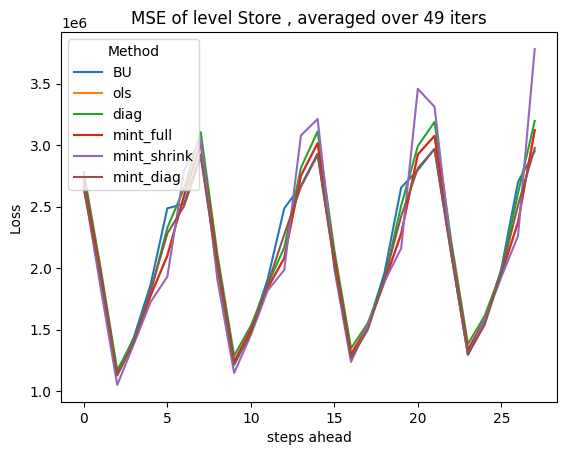

In [71]:
dOutputs=dOutputs_tuned

level='Store'
iters=int(dOutputs_default['bottom_up']['mYhat'].shape[1]/28)
metric='MSE'

vMethods=getCVResults( h=1, dOutputs=dOutputs , metric=metric , slices=slices  ,
                      iters = None, rolling=True).columns.get_level_values(0).unique()
vMethods=vMethods.drop(['top_down_ph','top_down_hp'])

plt.figure()
for method in vMethods:
    vValues = np.zeros(28)
    
    for h in range(1, 29):
        df = getCVResults(h=h, dOutputs=dOutputs ,metric=metric, slices=slices, 
                          iters=None, 
                          rolling=False, relative=False)[method]
        vValues[h-1] = df[df.index == level].item()    
    plt.plot(np.arange(28), vValues, label=method)

plt.legend(title="Method")
plt.xlabel("steps ahead")
plt.ylabel(f"Loss ")
plt.title(f"{metric} of level {level} , averaged over {iters} iters")

# Show the plot
plt.show()




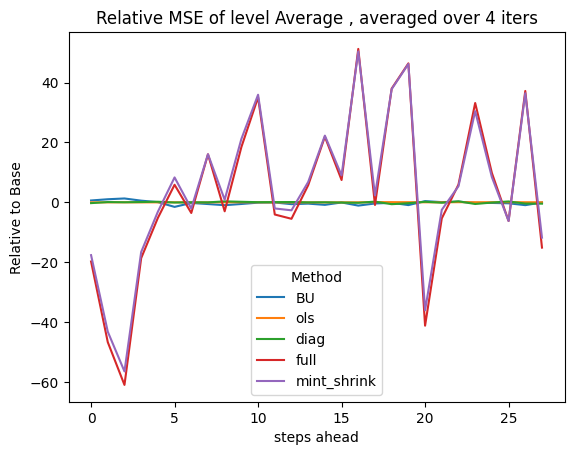

In [41]:
dOutputs=dOutputs_default

relative='Base'
level='Average'
iters=int(dOutputs_default['bottom_up']['mYhat'].shape[1]/28)
metric='MSE'

vMethods=getCVResults( h=1, dOutputs=dOutputs , metric=metric , slices=slices  ,
                      iters = None, rolling=False).columns.get_level_values(0).unique()
vMethods=vMethods.drop(['top_down_ph','top_down_hp'])

plt.figure()
for method in vMethods:
    vValues = np.zeros(28)
    
    for h in range(1, 29):
        df = getCVResults(h=h, dOutputs=dOutputs ,metric=metric, slices=slices, 
                          iters=None, 
                          rolling=False)[method]
        vValues[h-1] = df[df.index == level][relative].item()    
    plt.plot(np.arange(28), vValues, label=method)

plt.legend(title="Method")
plt.xlabel("steps ahead")
plt.ylabel(f"Relative to {relative}")
plt.title(f"Relative {metric} of level {level} , averaged over {iters} iters")

# Show the plot
plt.show()




# Tables


### MSE default

In [1176]:
metric='MSE'
# dOutputs=dOutputs_tuned
dOutputs=dOutputs_default


In [1177]:
getCVResults( h=1, dOutputs=dOutputs , metric=metric , slices=slices , rolling=True, iters=None)


Method      BU      top_down_ph         top_down_hp           ols        diag  \
Relative  Base   BU        Base      BU        Base      BU  Base    BU  Base   
Total     1.57 0.00       -0.00   -1.59       -0.00   -1.59  0.24 -1.35  1.76   
State     2.46 0.00      -12.03  -14.85      -13.00  -15.85  0.80 -1.70  2.72   
Store    -1.97 0.00      -76.13  -72.73      -81.58  -78.08 -2.19 -0.22 -1.41   
Cat.     -0.66 0.00      -88.55  -87.32      -96.59  -95.31 -0.52  0.14 -0.14   
Dept.     0.00 0.00     -101.45 -101.45     -109.99 -109.99  0.00  0.00  0.36   
Average   1.15 0.00      -23.54  -24.97      -25.45  -26.91  0.04 -1.12  1.43   

Method         full       mint_shrink       
Relative   BU  Base    BU        Base   BU  
Total    0.19 15.50 14.16        4.20 2.67  
State    0.27 16.30 14.19        4.86 2.46  
Store    0.55 12.96 14.64        1.94 3.83  
Cat.     0.51 13.24 13.80        3.36 3.99  
Dept.    0.36 14.85 14.85        4.25 4.25  
Average  0.29 15.21 14.23        4.05 2.94

In [1180]:
getCVResults( h=7, dOutputs=dOutputs , metric=metric , slices=slices , rolling=True, iters=None)

Method      BU      top_down_ph        top_down_hp           ols        diag  \
Relative  Base   BU        Base     BU        Base      BU  Base    BU  Base   
Total     1.73 0.00       -0.00  -1.76        0.00   -1.76  0.46 -1.30  1.89   
State     1.43 0.00      -21.48 -23.23      -23.98  -25.77  0.07 -1.37  1.61   
Store    -0.85 0.00      -74.30 -72.83      -80.36  -78.85 -1.36 -0.51 -0.51   
Cat.     -0.36 0.00      -82.99 -82.34      -90.81  -90.13 -0.50 -0.14 -0.10   
Dept.     0.00 0.00      -98.22 -98.22     -106.20 -106.20 -0.11 -0.11  0.15   
Average   1.11 0.00      -25.33 -26.74      -27.66  -29.10  0.06 -1.07  1.30   

Method         full       mint_shrink       
Relative   BU  Base    BU        Base   BU  
Total    0.16 -1.59 -3.38        2.93 1.22  
State    0.18  0.34 -1.10        2.12 0.70  
Store    0.33  4.07  4.88        1.80 2.63  
Cat.     0.26  4.44  4.78        2.31 2.66  
Dept.    0.15  6.08  6.08        3.01 3.01  
Average  0.19  0.40 -0.72        2.56 1.46

In [1182]:
getCVResults( h=14, dOutputs=dOutputs , metric=metric , slices=slices , rolling=True, iters=None)

Method      BU      top_down_ph        top_down_hp          ols        diag  \
Relative  Base   BU        Base     BU        Base     BU  Base    BU  Base   
Total     2.02 0.00        0.00  -2.06        0.00  -2.06  0.52 -1.52  2.14   
State     1.54 0.00      -20.77 -22.66      -23.26 -25.18  0.02 -1.54  1.69   
Store    -0.89 0.00      -70.12 -68.62      -75.96 -74.40 -1.48 -0.58 -0.56   
Cat.     -0.24 0.00      -76.57 -76.14      -83.98 -83.54 -0.48 -0.23 -0.01   
Dept.     0.00 0.00      -90.93 -90.93      -98.52 -98.52 -0.16 -0.16  0.13   
Average   1.28 0.00      -24.05 -25.66      -26.32 -27.96  0.06 -1.24  1.45   

Method         full       mint_shrink       
Relative   BU  Base    BU        Base   BU  
Total    0.13 -1.03 -3.11        3.23 1.24  
State    0.16  0.90 -0.64        2.23 0.71  
Store    0.33  4.46  5.30        1.98 2.85  
Cat.     0.24  4.74  4.97        2.57 2.81  
Dept.    0.13  5.38  5.38        3.12 3.12  
Average  0.17  0.87 -0.42        2.79 1.53

In [1183]:
getCVResults( h=21, dOutputs=dOutputs , metric=metric , slices=slices , rolling=True, iters=None, relative=True) 

Method      BU      top_down_ph        top_down_hp          ols        diag  \
Relative  Base   BU        Base     BU        Base     BU  Base    BU  Base   
Total     2.03 0.00        0.00  -2.08        0.00  -2.08  0.52 -1.55  2.14   
State     1.58 0.00      -20.68 -22.62      -23.20 -25.18  0.05 -1.56  1.73   
Store    -0.83 0.00      -68.17 -66.78      -73.90 -72.46 -1.44 -0.60 -0.52   
Cat.     -0.14 0.00      -73.95 -73.70      -81.19 -80.93 -0.43 -0.29  0.08   
Dept.     0.00 0.00      -87.54 -87.54      -94.94 -94.94 -0.19 -0.19  0.11   
Average   1.31 0.00      -23.75 -25.39      -26.02 -27.69  0.07 -1.26  1.46   

Method         full       mint_shrink       
Relative   BU  Base    BU        Base   BU  
Total    0.11 -0.58 -2.66        3.40 1.40  
State    0.15  1.91  0.33        2.40 0.84  
Store    0.31  5.91  6.69        2.31 3.12  
Cat.     0.22  6.61  6.74        3.01 3.15  
Dept.    0.11  5.03  5.03        3.33 3.33  
Average  0.15  1.67  0.37        3.00 1.72

In [1184]:
getCVResults( h=28, dOutputs=dOutputs , metric=metric , slices=slices , rolling=True, iters=None, relative=True) 

Method      BU      top_down_ph        top_down_hp          ols        diag  \
Relative  Base   BU        Base     BU        Base     BU  Base    BU  Base   
Total     2.05 0.00        0.00  -2.09        0.00  -2.09  0.52 -1.55  2.18   
State     1.61 0.00      -20.69 -22.67      -23.24 -25.27  0.06 -1.58  1.77   
Store    -0.74 0.00      -66.76 -65.54      -72.43 -71.16 -1.38 -0.64 -0.43   
Cat.     -0.16 0.00      -72.41 -72.13      -79.55 -79.26 -0.46 -0.30  0.06   
Dept.     0.00 0.00      -85.19 -85.19      -92.46 -92.46 -0.19 -0.19  0.11   
Average   1.32 0.00      -23.58 -25.24      -25.86 -27.55  0.07 -1.27  1.49   

Method         full       mint_shrink       
Relative   BU  Base    BU        Base   BU  
Total    0.14 -1.34 -3.46        3.67 1.66  
State    0.16  1.87  0.26        2.64 1.04  
Store    0.31  6.37  7.06        2.64 3.35  
Cat.     0.22  7.20  7.35        3.27 3.43  
Dept.    0.11  3.17  3.17        3.50 3.50  
Average  0.17  1.30 -0.02        3.26 1.96


### MSE tuned

In [1204]:
metric='MSE'
dOutputs=dOutputs_tuned


In [1205]:
getCVResults( h=1, dOutputs=dOutputs , metric=metric , slices=slices , rolling=True, iters=None)


Method      BU      top_down_ph         top_down_hp           ols       diag  \
Relative  Base   BU        Base      BU        Base      BU  Base    BU Base   
Total     3.78 0.00       -0.00   -3.93       -0.00   -3.93 -0.13 -4.06 3.12   
State     4.97 0.00      -20.56  -26.86      -21.97  -28.35  3.50 -1.55 6.47   
Store    -1.00 0.00     -113.83 -111.72     -121.15 -118.96 -1.95 -0.94 0.78   
Cat.     -2.51 0.00     -150.87 -144.72     -162.61 -156.17 -0.58  1.89 0.47   
Dept.     0.00 0.00     -149.56 -149.56     -160.69 -160.69  0.69  0.69 1.93   
Average   2.87 0.00      -37.81  -41.88      -40.51  -44.65  0.62 -2.31 3.46   

Method           full        mint_shrink        
Relative    BU   Base     BU        Base    BU  
Total    -0.68 -13.13 -17.58       -3.38 -7.44  
State     1.58  -5.66 -11.19        3.23 -1.83  
Store     1.77  -5.45  -4.41       -0.08  0.91  
Cat.      2.91  -0.99   1.49        2.96  5.34  
Dept.     1.93   3.16   3.16        5.89  5.89  
Average   0.62  -8.51 -11.71       -0.30 -3.26

In [1206]:
getCVResults( h=7, dOutputs=dOutputs , metric=metric , slices=slices , rolling=True, iters=None)

Method      BU      top_down_ph         top_down_hp           ols       diag  \
Relative  Base   BU        Base      BU        Base      BU  Base   BU  Base   
Total    -5.69 0.00       -0.00    5.38        0.00    5.38 -0.16 5.23 -2.99   
State    -2.30 0.00      -36.16  -33.10      -39.60  -36.47  2.18 4.38  0.80   
Store    -0.48 0.00     -112.72 -111.71     -120.92 -119.87  2.53 2.99  2.34   
Cat.      1.77 0.00     -133.00 -137.20     -143.89 -148.29  3.46 1.71  4.24   
Dept.     0.00 0.00     -138.20 -138.20     -148.33 -148.33  0.74 0.74  1.96   
Average  -3.31 0.00      -40.64  -36.14      -43.91  -39.30  1.08 4.25 -0.56   

Method         full       mint_shrink       
Relative   BU  Base    BU        Base   BU  
Total    2.55 -9.76 -3.85       -3.33 2.23  
State    3.02 -5.55 -3.18        0.84 3.07  
Store    2.81  0.41  0.89        4.57 5.02  
Cat.     2.51  6.61  4.93        9.48 7.84  
Dept.    1.96  6.14  6.14        8.80 8.80  
Average  2.66 -5.30 -1.92        0.36 3.55

In [1207]:
getCVResults( h=14, dOutputs=dOutputs , metric=metric , slices=slices , rolling=True, iters=None)

Method      BU      top_down_ph         top_down_hp           ols       diag  \
Relative  Base   BU        Base      BU        Base      BU  Base   BU  Base   
Total    -5.82 0.00        0.00    5.50        0.00    5.50 -0.23 5.28 -2.79   
State    -1.44 0.00      -35.90  -33.96      -39.36  -37.38  2.62 4.00  1.64   
Store    -0.41 0.00     -110.78 -109.92     -118.84 -117.95  1.89 2.29  2.08   
Cat.      2.41 0.00     -126.61 -132.19     -137.11 -142.95  3.51 1.13  4.43   
Dept.     0.00 0.00     -131.06 -131.06     -140.81 -140.81  0.49 0.49  1.48   
Average  -3.06 0.00      -40.01  -35.85      -43.26  -39.00  1.09 4.03 -0.26   

Method          full       mint_shrink       
Relative   BU   Base    BU        Base   BU  
Total    2.86 -14.91 -8.59       -5.57 0.24  
State    3.04  -9.28 -7.73        0.06 1.48  
Store    2.48  -3.40 -2.98        3.04 3.44  
Cat.     2.08   4.10  1.73        8.81 6.56  
Dept.    1.48   2.93  2.93        7.25 7.25  
Average  2.72  -9.53 -6.27       -1.20 1.81

In [1208]:
getCVResults( h=21, dOutputs=dOutputs , metric=metric , slices=slices , rolling=True, iters=None, relative=True) 

Method      BU      top_down_ph         top_down_hp           ols       diag  \
Relative  Base   BU        Base      BU        Base      BU  Base   BU  Base   
Total    -6.31 0.00        0.00    5.93        0.00    5.93 -0.38 5.58 -3.09   
State    -1.27 0.00      -35.70  -34.00      -39.19  -37.44  2.87 4.09  1.89   
Store     0.52 0.00     -106.92 -108.00     -114.77 -115.88  2.38 1.87  2.86   
Cat.      2.52 0.00     -122.81 -128.57     -133.03 -139.05  3.37 0.87  4.34   
Dept.     0.00 0.00     -126.15 -126.15     -135.61 -135.61  0.36 0.36  1.27   
Average  -3.11 0.00      -39.44  -35.22      -42.66  -38.35  1.12 4.11 -0.25   

Method          full        mint_shrink        
Relative   BU   Base     BU        Base    BU  
Total    3.03 -20.84 -13.67       -8.38 -1.95  
State    3.12 -13.99 -12.55       -1.70 -0.43  
Store    2.35  -6.43  -6.98        2.08  1.57  
Cat.     1.86   1.13  -1.43        7.45  5.05  
Dept.    1.27  -0.27  -0.27        5.64  5.64  
Average  2.78 -14.33 -10.88       -3.29 -0.17

In [1209]:
getCVResults( h=28, dOutputs=dOutputs , metric=metric , slices=slices , rolling=True, iters=None, relative=True) 

Method      BU      top_down_ph         top_down_hp           ols       diag  \
Relative  Base   BU        Base      BU        Base      BU  Base   BU  Base   
Total    -6.58 0.00        0.00    6.17        0.00    6.17 -0.50 5.70 -3.36   
State    -1.07 0.00      -35.14  -33.70      -38.64  -37.17  3.09 4.12  2.05   
Store     1.50 0.00     -102.73 -105.82     -110.37 -113.57  2.83 1.35  3.56   
Cat.      2.70 0.00     -118.62 -124.69     -128.58 -134.92  3.27 0.59  4.28   
Dept.     0.00 0.00     -121.24 -121.24     -130.44 -130.44  0.22 0.22  1.04   
Average  -3.03 0.00      -38.65  -34.57      -41.86  -37.69  1.17 4.07 -0.25   

Method          full        mint_shrink        
Relative   BU   Base     BU        Base    BU  
Total    3.01 -26.23 -18.44      -10.48 -3.66  
State    3.09 -18.32 -17.06       -3.03 -1.93  
Store    2.09  -9.08 -10.74        1.47 -0.03  
Cat.     1.62  -1.60  -4.42        6.31  3.71  
Dept.    1.04  -3.04  -3.04        4.26  4.26  
Average  2.70 -18.66 -15.17       -4.83 -1.75

### MAPE relative

In [1133]:
metric='MAPE'
dOutputs=dOutputs_default

In [1134]:
getCVResults( h=1, dOutputs=dOutputs , metric=metric , slices=slices , rolling=True, iters=None)



Method      BU      top_down_ph        top_down_hp          ols        diag  \
Relative  Base   BU        Base     BU        Base     BU  Base    BU  Base   
Total     0.58 0.00       -0.00  -0.58       -0.00  -0.58  0.09 -0.49  0.83   
State     0.56 0.00       -3.34  -3.92       -3.96  -4.55  0.38 -0.18  0.81   
Store    -0.73 0.00      -33.00 -32.03      -35.76 -34.77 -0.75 -0.01 -0.57   
Cat.      0.04 0.00      -40.69 -40.74      -44.40 -44.46 -0.73 -0.77  0.13   
Dept.     0.00 0.00      -16.72 -16.72      -18.60 -18.60  1.57  1.57  0.05   
Average  -0.02 0.00      -21.94 -21.91      -24.19 -24.16  0.99  1.01  0.04   

Method        full      mint_shrink       
Relative   BU Base   BU        Base   BU  
Total    0.25 8.21 7.67        2.15 1.58  
State    0.25 7.28 6.75        1.89 1.33  
Store    0.17 4.02 4.72        0.07 0.80  
Cat.     0.09 3.71 3.67        1.53 1.49  
Dept.    0.05 6.42 6.42        1.89 1.89  
Average  0.07 5.79 5.81        1.72 1.75

In [1135]:
getCVResults( h=7, dOutputs=dOutputs , metric=metric , slices=slices , rolling=True, iters=None)

Method      BU      top_down_ph        top_down_hp          ols        diag  \
Relative  Base   BU        Base     BU        Base     BU  Base    BU  Base   
Total     0.66 0.00        0.00  -0.66       -0.00  -0.66  0.10 -0.56  0.50   
State     1.21 0.00      -16.30 -17.72      -18.22 -19.67  0.23 -0.99  1.05   
Store    -0.03 0.00      -47.81 -47.77      -51.19 -51.15 -0.22 -0.19 -0.09   
Cat.      0.17 0.00      -54.78 -55.04      -58.39 -58.66  0.37  0.20  0.16   
Dept.     0.00 0.00      -30.92 -30.92      -33.29 -33.29  1.78  1.78 -0.01   
Average   0.06 0.00      -36.61 -36.69      -39.29 -39.37  1.33  1.28  0.04   

Method          full       mint_shrink       
Relative    BU  Base    BU        Base   BU  
Total    -0.16  0.03 -0.63        1.01 0.35  
State    -0.16 -0.33 -1.56        1.57 0.36  
Store    -0.06  0.11  0.14        0.63 0.66  
Cat.     -0.01  0.57  0.39        0.80 0.63  
Dept.    -0.01  1.56  1.56        1.72 1.72  
Average  -0.02  1.23  1.17        1.46 1.40

In [1136]:
getCVResults( h=14, dOutputs=dOutputs , metric=metric , slices=slices , rolling=True, iters=None)

Method      BU      top_down_ph        top_down_hp          ols        diag  \
Relative  Base   BU        Base     BU        Base     BU  Base    BU  Base   
Total     1.04 0.00        0.00  -1.05        0.00  -1.05  0.21 -0.84  0.93   
State     1.12 0.00      -15.68 -17.00      -17.58 -18.92  0.10 -1.04  0.95   
Store    -0.04 0.00      -46.10 -46.04      -49.46 -49.40 -0.42 -0.38 -0.12   
Cat.      0.22 0.00      -53.23 -53.56      -56.76 -57.10  0.15 -0.07  0.20   
Dept.     0.00 0.00      -29.31 -29.31      -31.63 -31.63  1.70  1.70 -0.00   
Average   0.07 0.00      -35.02 -35.11      -37.64 -37.73  1.22  1.15  0.05   

Method          full       mint_shrink       
Relative    BU  Base    BU        Base   BU  
Total    -0.11 -0.32 -1.38        1.15 0.11  
State    -0.17  0.76 -0.37        1.32 0.20  
Store    -0.08 -0.65 -0.61        0.46 0.50  
Cat.     -0.02  1.28  1.06        0.92 0.70  
Dept.    -0.00  1.77  1.77        1.79 1.79  
Average  -0.01  1.50  1.43        1.52 1.45

In [1137]:
getCVResults( h=28, dOutputs=dOutputs , metric=metric , slices=slices , rolling=True, iters=None) 

Method     BU      top_down_ph        top_down_hp          ols        diag  \
Relative Base   BU        Base     BU        Base     BU  Base    BU  Base   
Total    0.61 0.00        0.00  -0.62       -0.00  -0.62  0.07 -0.55  0.58   
State    0.90 0.00      -17.53 -18.60      -19.68 -20.78  0.29 -0.62  0.83   
Store    0.26 0.00      -46.86 -47.24      -50.26 -50.65 -0.20 -0.46  0.21   
Cat.     0.20 0.00      -51.48 -51.78      -54.93 -55.23 -0.04 -0.24  0.18   
Dept.    0.00 0.00      -26.79 -26.79      -29.10 -29.10  1.91  1.91 -0.02   
Average  0.07 0.00      -32.91 -33.01      -35.51 -35.61  1.35  1.27  0.05   

Method          full       mint_shrink       
Relative    BU  Base    BU        Base   BU  
Total    -0.03 -3.69 -4.33        0.93 0.32  
State    -0.08  0.66 -0.24        1.58 0.68  
Store    -0.06 -2.97 -3.24        0.57 0.31  
Cat.     -0.02 -0.12 -0.32        0.82 0.62  
Dept.    -0.02 -3.98 -3.98        1.59 1.59  
Average  -0.02 -3.04 -3.11        1.37 1.30

### MSE relative

In [1153]:
dOutputs=dOutputs_default
metric='RMSE'

In [1154]:
getCVResults( h=1, dOutputs=dOutputs , metric=metric , slices=slices , rolling=True, iters=None)



Method      BU      top_down_ph        top_down_hp          ols        diag  \
Relative  Base   BU        Base     BU        Base     BU  Base    BU  Base   
Total     0.79 0.00       -0.00  -0.79       -0.00  -0.79  0.12 -0.67  0.88   
State     1.24 0.00       -5.84  -7.17       -6.30  -7.63  0.40 -0.85  1.37   
Store    -0.98 0.00      -32.71 -31.43      -34.75 -33.45 -1.09 -0.11 -0.70   
Cat.     -0.33 0.00      -37.31 -36.87      -40.21 -39.75 -0.26  0.07 -0.07   
Dept.     0.00 0.00      -41.93 -41.93      -44.91 -44.91  0.00  0.00  0.18   
Average   0.58 0.00      -11.15 -11.79      -12.00 -12.65  0.02 -0.56  0.72   

Method        full      mint_shrink       
Relative   BU Base   BU        Base   BU  
Total    0.10 8.08 7.35        2.12 1.35  
State    0.13 8.51 7.37        2.46 1.24  
Store    0.27 6.70 7.61        0.97 1.93  
Cat.     0.26 6.85 7.16        1.70 2.02  
Dept.    0.18 7.72 7.72        2.15 2.15  
Average  0.14 7.92 7.39        2.05 1.48

In [1155]:
getCVResults( h=7, dOutputs=dOutputs , metric=metric , slices=slices , rolling=True, iters=None)

Method      BU      top_down_ph        top_down_hp          ols        diag  \
Relative  Base   BU        Base     BU        Base     BU  Base    BU  Base   
Total     0.92 0.00        0.00  -0.93       -0.00  -0.93  0.21 -0.71  0.79   
State     0.90 0.00      -15.38 -16.43      -16.89 -17.95 -0.02 -0.93  0.76   
Store    -0.57 0.00      -47.62 -46.79      -50.22 -49.37 -0.69 -0.12 -0.43   
Cat.      0.10 0.00      -49.79 -49.95      -53.01 -53.17 -0.03 -0.13  0.15   
Dept.     0.00 0.00      -56.73 -56.73      -59.99 -59.99 -0.09 -0.09 -0.02   
Average   0.64 0.00      -17.40 -18.16      -18.67 -19.43  0.02 -0.62  0.56   

Method         full      mint_shrink       
Relative    BU Base   BU        Base   BU  
Total    -0.13 1.23 0.32        1.61 0.70  
State    -0.14 2.58 1.70        1.52 0.63  
Store     0.13 3.64 4.18        1.36 1.91  
Cat.      0.05 3.79 3.69        2.00 1.90  
Dept.    -0.02 3.33 3.33        2.09 2.09  
Average  -0.09 2.13 1.49        1.61 0.98

In [1156]:

getCVResults( h=14, dOutputs=dOutputs , metric=metric , slices=slices , rolling=True, iters=None)

Method      BU      top_down_ph        top_down_hp          ols        diag  \
Relative  Base   BU        Base     BU        Base     BU  Base    BU  Base   
Total     1.09 0.00        0.00  -1.10        0.00  -1.10  0.25 -0.85  0.92   
State     0.90 0.00      -14.97 -16.01      -16.43 -17.49 -0.09 -0.99  0.72   
Store    -0.55 0.00      -44.67 -43.88      -47.14 -46.33 -0.70 -0.14 -0.44   
Cat.      0.29 0.00      -45.88 -46.32      -48.91 -49.35  0.05 -0.25  0.30   
Dept.     0.00 0.00      -52.87 -52.87      -55.96 -55.96 -0.15 -0.15 -0.06   
Average   0.74 0.00      -16.49 -17.36      -17.70 -18.58  0.03 -0.72  0.62   

Method         full       mint_shrink       
Relative    BU Base    BU        Base   BU  
Total    -0.17 0.82 -0.27        1.65 0.57  
State    -0.18 3.24  2.37        1.46 0.57  
Store     0.11 4.97  5.49        1.45 1.99  
Cat.      0.01 6.03  5.76        2.37 2.08  
Dept.    -0.06 3.82  3.82        2.18 2.18  
Average  -0.12 2.43  1.70        1.67 0.93

In [1157]:
getCVResults( h=28, dOutputs=dOutputs , metric=metric , slices=slices , rolling=True, iters=None) 

Method      BU      top_down_ph        top_down_hp          ols        diag  \
Relative  Base   BU        Base     BU        Base     BU  Base    BU  Base   
Total     0.76 0.00        0.00  -0.76        0.00  -0.76  0.18 -0.59  0.74   
State     1.05 0.00      -15.20 -16.42      -16.75 -17.99  0.10 -0.97  0.95   
Store    -0.41 0.00      -43.53 -42.94      -45.94 -45.34 -0.59 -0.18 -0.27   
Cat.      0.01 0.00      -45.13 -45.14      -48.09 -48.10 -0.11 -0.12  0.09   
Dept.     0.00 0.00      -50.83 -50.83      -53.84 -53.84 -0.08 -0.08  0.03   
Average   0.59 0.00      -16.79 -17.49      -18.03 -18.74  0.03 -0.57  0.59   

Method          full       mint_shrink       
Relative    BU  Base    BU        Base   BU  
Total    -0.02 -3.43 -4.22        1.43 0.68  
State    -0.10  1.04 -0.01        1.72 0.68  
Store     0.14  3.75  4.14        1.69 2.09  
Cat.      0.08  3.34  3.33        2.32 2.31  
Dept.     0.03 -3.37 -3.37        2.24 2.24  
Average  -0.01 -0.94 -1.54        1.65 1.06